# **AMERICAN SIGN LANGUAGE RECOGNITION PROJECT**

# Setting up the environment and kaggle API

**Importing tensorflow and checking tensorflow:**

In [2]:
import tensorflow as tf

print(tf.__version__)

2.7.0


**Installing kaggle so as to download the dataset using kaggle API:**

**Setting up the kaggle.json authentication file enabling me to download the dataset:**

# Downloading the grassknoted/asl-alphabet available [here](https://www.kaggle.com/grassknoted/asl-alphabet)

**Downloading the dataset using the API:**

**Extracting the contents:**

# Looking at the dataset

**Specifying train and test directories:**

In [ ]:
# Specifying the training and test directories

TRAINING_DIR = './asl_alphabet_train/asl_alphabet_train/'
TEST_DIR = './asl_alphabet_test/asl_alphabet_test/'

**Looking at some random images from the dataset:**

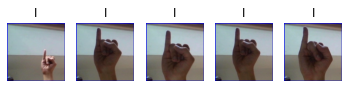

In [3]:
# Printing 5 random images from any training category or from a specified category
%matplotlib inline

import cv2
import os
import random
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

number_of_rows = 1
number_of_columns = 5

categories = os.listdir(TRAINING_DIR)

random.seed(13)

category = categories[random.randint(1, 30)]
# category = 'A'

for i in range(number_of_columns):
  subplot = plt.subplot(number_of_rows, number_of_columns, i + 1)
  subplot.axis('Off')
  subplot.set_title(category)
  image_path = os.path.join(
      TRAINING_DIR,
      str(category),
      str(category) + str(random.randint(1, 1000)) + '.jpg'
  )
  image = mpimg.imread(image_path)
  plt.imshow(image)
  
plt.show()

# Preparing the training set

**Augmenting the data with brightness and zoom ranges:**

In [4]:
# Preparing ImageDataGenerator object for training the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 200
BATCH_SIZE = 64

data_generator = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization=True,
    brightness_range=[0.8, 1.0],
    zoom_range=[1.0, 1.2],
    validation_split=0.1
)

train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


# Preparing the model for training

**Downloading custom weight file if required:**

**Preparing Inception V3 Network for transfer learning:**

In [5]:
# Loading inception v3 network for transfer learning
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3

WEIGHTS_FILE = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

inception_v3_model = InceptionV3(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), 
    include_top = False, 
    weights = 'imagenet'
)

# Not required --> inception_v3_model.load_weights(WEIGHTS_FILE)


    
# Checking model summary to pick a layer (if required)
inception_v3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

**Choosing the inception output layer:**

In [6]:
# Choosing the output layer to be merged with our FC layers (if required)
inception_output_layer = inception_v3_model.get_layer('mixed7')
print('Inception model output shape:', inception_output_layer.output_shape)

# Not required --> inception_output = inception_output_layer.output
inception_output = inception_v3_model.output

Inception model output shape: (None, 10, 10, 768)


**Adding our own set of fully connected layers at the end of Inception v3 network:**

In [7]:
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

x = layers.GlobalAveragePooling2D()(inception_output)
x = layers.Dense(1024, activation='relu')(x)
# Not required --> x = layers.Dropout(0.2)(x)                  
x = layers.Dense(29, activation='softmax')(x)           

model = Model(inception_v3_model.input, x) 

model.compile(
    optimizer=SGD(lr=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['acc']
)

C:\Users\sanka\Anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


**Looking at the final model:**

In [8]:
# Watch the new model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

activation_85 (Activation)      (None, 4, 4, 320)    0           batch_normalization_85[0][0]     
__________________________________________________________________________________________________
mixed9_1 (Concatenate)          (None, 4, 4, 768)    0           activation_87[0][0]              
                                                                 activation_88[0][0]              
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 4, 4, 768)    0           activation_91[0][0]              
                                                                 activation_92[0][0]              
__________________________________________________________________________________________________
activation_93 (Activation)      (None, 4, 4, 192)    0           batch_normalization_93[0][0]     
__________________________________________________________________________________________________
mixed10 (C

**Setting up a callback funtion in order to stop training at a particular threshold:**

In [9]:
# Creating a callback to stop model training after reaching a threshold accuracy

LOSS_THRESHOLD = 0.2
ACCURACY_THRESHOLD = 0.95

class ModelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_loss') <= LOSS_THRESHOLD and logs.get('val_acc') >= ACCURACY_THRESHOLD:
      print("\nReached", ACCURACY_THRESHOLD * 100, "accuracy, Stopping!")
      self.model.stop_training = True

callback = ModelCallback()

# Training the model generated using Inception v3 and our own set of Fully Connected layers

**Fitting the model to the training dataset:**

In [10]:
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    validation_steps=50,
    epochs=50,
    callbacks=[callback]
)

C:\Users\sanka\Anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
100/100 [==============================] - 1230s 12s/step - loss: 3.3769 - acc: 0.0528 - val_loss: 3.3544 - val_acc: 0.0603
Epoch 2/50
100/100 [==============================] - 1214s 12s/step - loss: 3.1518 - acc: 0.1538 - val_loss: 3.1226 - val_acc: 0.1444
Epoch 3/50
100/100 [==============================] - 1364s 14s/step - loss: 2.9169 - acc: 0.3142 - val_loss: 2.9466 - val_acc: 0.2572
Epoch 4/50
100/100 [==============================] - 1403s 14s/step - loss: 2.6417 - acc: 0.4588 - val_loss: 2.7088 - val_acc: 0.3741
Epoch 5/50
100/100 [==============================] - 1227s 12s/step - loss: 2.3236 - acc: 0.5844 - val_loss: 2.4235 - val_acc: 0.4834
Epoch 6/50
100/100 [==============================] - 1236s 12s/step - loss: 2.0038 - acc: 0.6891 - val_loss: 2.1056 - val_acc: 0.6041
Epoch 7/50
100/100 [==============================] - 1210s 12s/step - loss: 1.6902 - acc: 0.7658 - val_loss: 1.7934 - val_acc: 0.6906
Epoch 8/50
100/100 [==============================] - 1

# Plotting the results

**Training Accuracy vs Validation Accuracy:**

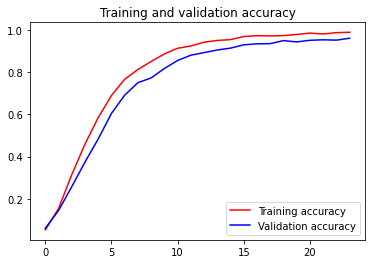

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

**Training Loss vs Validation Loss**

<Figure size 432x288 with 0 Axes>

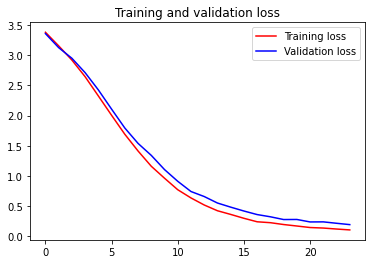

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

# Saving the model

**As we were satisfied with our results we save our model:**

In [33]:
# Saving the model
MODEL_NAME = 'models/asl_alphabet_{}.h5'.format(9575)
model.save(MODEL_NAME)

**Plotting images along with their respective actual and predicted classes:**

Actual class: A 
 Predicted class: A


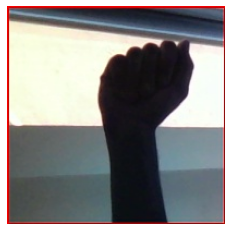

Actual class: B 
 Predicted class: B


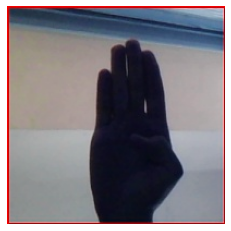

Actual class: C 
 Predicted class: C


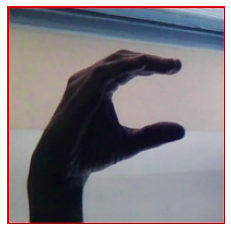

Actual class: D 
 Predicted class: D


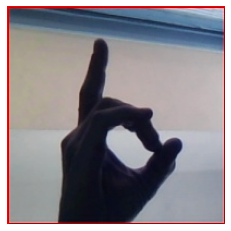

Actual class: E 
 Predicted class: E


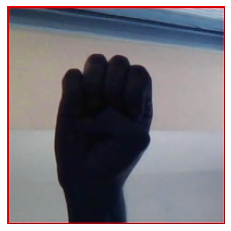

Actual class: F 
 Predicted class: F


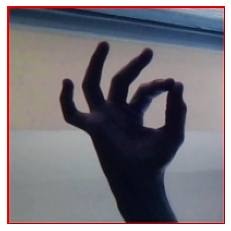

Actual class: G 
 Predicted class: G


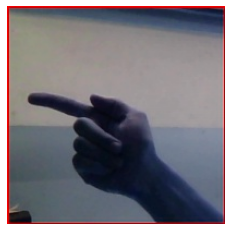

Actual class: H 
 Predicted class: H


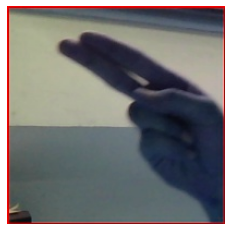

Actual class: I 
 Predicted class: I


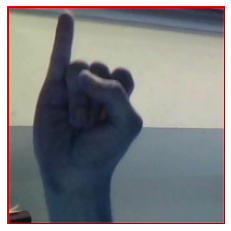

Actual class: J 
 Predicted class: J


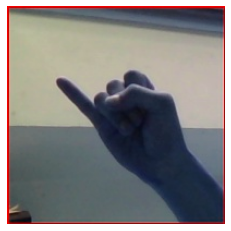

Actual class: K 
 Predicted class: K


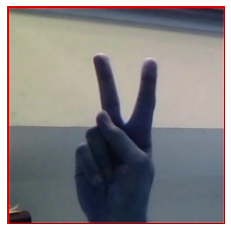

Actual class: L 
 Predicted class: L


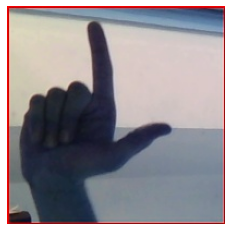

Actual class: M 
 Predicted class: M


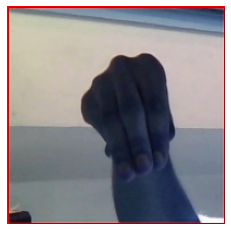

Actual class: nothing 
 Predicted class: nothing


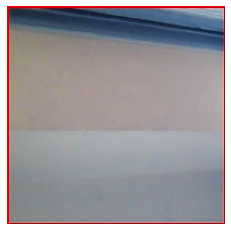

Actual class: N 
 Predicted class: N


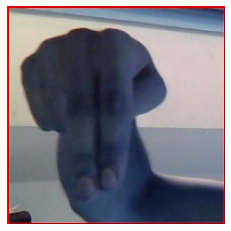

Actual class: O 
 Predicted class: O


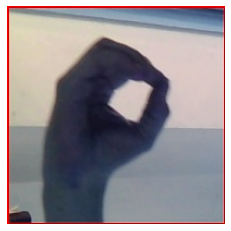

Actual class: P 
 Predicted class: P


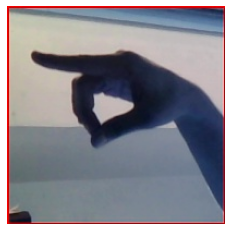

Actual class: Q 
 Predicted class: Q


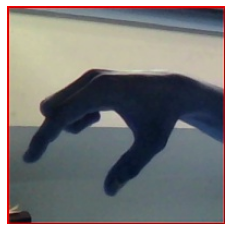

Actual class: R 
 Predicted class: R


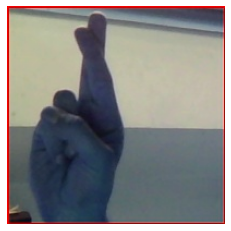

Actual class: space 
 Predicted class: space


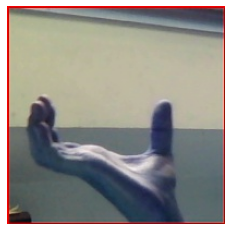

Actual class: S 
 Predicted class: S


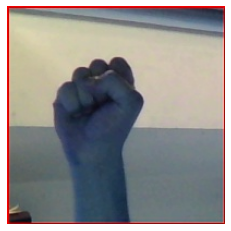

Actual class: T 
 Predicted class: T


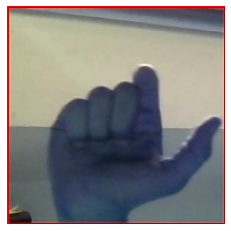

Actual class: U 
 Predicted class: U


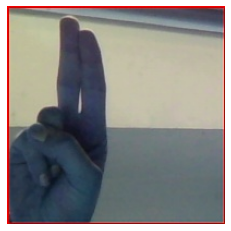

Actual class: V 
 Predicted class: V


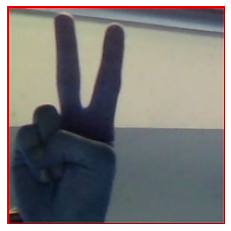

Actual class: W 
 Predicted class: W


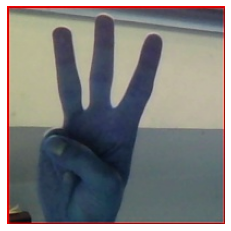

Actual class: X 
 Predicted class: X


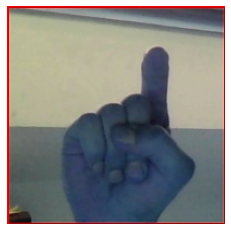

Actual class: Y 
 Predicted class: G


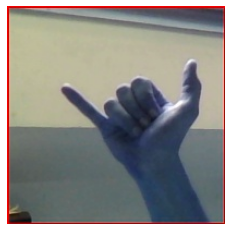

Actual class: Z 
 Predicted class: Z


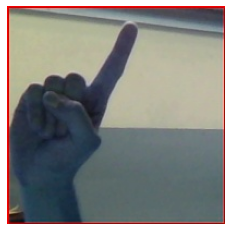

In [34]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

classes = os.listdir(TRAINING_DIR)
classes.sort()

for i, test_image in enumerate(os.listdir(TEST_DIR)):
    image_location = TEST_DIR + test_image
    img = cv2.imread(image_location)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    plt.figure()
    plt.axis('Off')
    plt.imshow(img)
    img = np.array(img) / 255.
    img = img.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))
    img = data_generator.standardize(img)
    prediction = np.array(model.predict(img))
    actual = test_image.split('_')[0]
    predicted = classes[prediction.argmax()]
    print('Actual class: {} \n Predicted class: {}'.format(actual, predicted))
    plt.show()

**Calculating test accuracy:**

In [35]:
test_images = os.listdir(TEST_DIR)
total_test_cases = len(test_images)
total_correctly_classified = 0
total_misclassified = 0
for i, test_image in enumerate(test_images):
    image_location = TEST_DIR + test_image
    img = cv2.imread(image_location)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = np.array(img) / 255.
    img = img.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))
    img = data_generator.standardize(img)
    prediction = np.array(model.predict(img))
    actual = test_image.split('_')[0]
    predicted = classes[prediction.argmax()]
    print('Actual class: {} - Predicted class: {}'.format(
        actual, predicted), end=' ')
    if actual == predicted:
      print('PASS!')
      total_correctly_classified += 1
    else:
      print('FAIL!')
      total_misclassified += 1
print("=" * 20)
test_accuracy = (total_correctly_classified / total_test_cases) * 100
test_error_rate = (total_misclassified / total_test_cases) * 100

print('Test accuracy (%):', test_accuracy)
print('Test error rate (%):', test_error_rate)
print('Number of misclassified classes:', total_misclassified)
print('Number of correctly classified classes', total_correctly_classified)

Actual class: A - Predicted class: A PASS!
Actual class: B - Predicted class: B PASS!
Actual class: C - Predicted class: C PASS!
Actual class: D - Predicted class: D PASS!
Actual class: E - Predicted class: E PASS!
Actual class: F - Predicted class: F PASS!
Actual class: G - Predicted class: G PASS!
Actual class: H - Predicted class: H PASS!
Actual class: I - Predicted class: I PASS!
Actual class: J - Predicted class: J PASS!
Actual class: K - Predicted class: K PASS!
Actual class: L - Predicted class: L PASS!
Actual class: M - Predicted class: M PASS!
Actual class: nothing - Predicted class: nothing PASS!
Actual class: N - Predicted class: N PASS!
Actual class: O - Predicted class: O PASS!
Actual class: P - Predicted class: P PASS!
Actual class: Q - Predicted class: Q PASS!
Actual class: R - Predicted class: R PASS!
Actual class: space - Predicted class: space PASS!
Actual class: S - Predicted class: S PASS!
Actual class: T - Predicted class: T PASS!
Actual class: U - Predicted class:

In [ ]:
import cv2
import numpy as np

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Prepare data generator for standardizing frames before sending them into the model.
data_generator = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)

# Loading the model.
MODEL_NAME = 'models/asl1_alphabet_{}.h5'.format(9575)
model = load_model(MODEL_NAME)

# Setting up the input image size and frame crop size.
IMAGE_SIZE = 200
CROP_SIZE = 200

# Creating list of available classes stored in classes.txt.
classes_file = open("classes.txt")
classes_string = classes_file.readline()
classes = classes_string.split()
classes.sort()  # The predict function sends out output in sorted order.

# Preparing cv2 for webcam feed
cap = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame.
    ret, frame = cap.read()

    # Target area where the hand gestures should be.
    cv2.rectangle(frame , (0, 0), (CROP_SIZE, CROP_SIZE), (0, 255, 0), 3)
    
    # Preprocessing the frame before input to the model.
    cropped_image = frame[0:CROP_SIZE, 0:CROP_SIZE]
    resized_frame = cv2.resize(cropped_image, (IMAGE_SIZE, IMAGE_SIZE))
    reshaped_frame = (np.array(resized_frame)).reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))
    frame_for_model = data_generator.standardize(np.float64(reshaped_frame))

    # Predicting the frame.
    prediction = np.array(model.predict(frame_for_model))
    predicted_class = classes[prediction.argmax()]      # Selecting the max confidence index.

    # Preparing output based on the model's confidence.
    prediction_probability = prediction[0, prediction.argmax()]
    if prediction_probability > 0.5:
        # High confidence.
        cv2.putText(frame, '{} - {:.2f}%'.format(predicted_class, prediction_probability * 100), 
                                    (10, 450), 1, 2, (255, 255, 0), 2, cv2.LINE_AA)
    elif prediction_probability > 0.2 and prediction_probability <= 0.5:
        # Low confidence.
        cv2.putText(frame, 'Maybe {}... - {:.2f}%'.format(predicted_class, prediction_probability * 100), 
                                    (10, 450), 1, 2, (0, 255, 255), 2, cv2.LINE_AA)
    else:
        # No confidence.
        cv2.putText(frame, classes[-2], (10, 450), 1, 2, (255, 255, 0), 2, cv2.LINE_AA)

    # Display the image with prediction.
    cv2.imshow('frame', frame)

    # Press q to quit
    k = cv2.waitKey(1) & 0xFF
    if k == ord('q'):
        break

# When everything done, release the capture.
cap.release()
cv2.destroyAllWindows()